# Comparative Analysis of Osteocyte Morphology: Control vs. LTBP3-Deficient Cells

## Overview
This notebook presents a comprehensive analysis of cell morphology features in 2D osteocyte cultures comparing wildtype (Control) and LTBP3-deficient (mutant) conditions for an MSc Data Science thesis. LTBP3 (Latent Transforming Growth Factor Beta Binding Protein 3) modulates TGF-β bioavailability, critical for bone homeostasis. LTBP3 deficiency leads to skeletal abnormalities (e.g., osteosclerosis, osteoarthritis) due to impaired TGF-β signaling, affecting osteoclast function and potentially osteocyte morphology. Prior studies suggest LTBP3-deficient osteocytes exhibit hypertrophy (larger cell size, planar spreading) and increased branching (more irregular, elongated shapes), which we quantify here using morphological metrics.

## Objectives
- Quantify differences in cell size (area, convex area, bounding box area, equivalent diameter, perimeter) and shape/branching (extent, eccentricity, form factor, solidity, compactness).
- Validate prior findings: hypertrophy (larger size metrics) and increased branching (lower extent, higher eccentricity, form factor, solidity, compactness).
- Use advanced data science techniques (PCA, t-SNE, clustering) to explore group separation and feature importance.
- Ensure robust statistical analysis with outlier handling and reproducibility for thesis quality.

## Data
Data is loaded from CSV files in `results/metrics/wildtype/` and `results/metrics/mutant/`. Features include:
- **Size-related**: `area`, `convex_area`, `bounding_box_area`, `equivalent_diameter`, `perimeter` (indicating hypertrophy, planar spreading).
- **Shape/branching-related**: `extent` (bounding box fill, lower for branching), `eccentricity` (elongation), `form_factor` (shape smoothness), `solidity` (protrusion extent), `compactness` (contour irregularity).
If no files are found, an error is raised. Ensure the main workflow script has been executed.

## Analyses
1. **Data Quality Check**: Verify data integrity, handle missing values, and detect outliers.
2. **Statistical Summary**: Descriptive statistics, normality tests, effect sizes (Cohen’s d with confidence intervals).
3. **Correlation Analysis**: Correlation heatmap and network to identify feature relationships.
4. **Dimensionality Reduction**: PCA (with biplot) and t-SNE for visualization, with outlier handling.
5. **Feature Importance**: PCA loadings to highlight key morphological drivers.
6. **Feature Distributions**: Combined violin-box plots with outlier markers to compare size and shape metrics.
7. **Clustering**: K-Means with silhouette scores to assess group separation.

## Statistical Notes
- **Normality**: Shapiro-Wilk test to justify non-parametric Mann-Whitney U test for comparisons.
- **Significance**: Bonferroni-adjusted p-values (α=0.05/10=0.005 for 10 features).
- **Effect Size**: Cohen’s d (|d| < 0.2 small, 0.2–0.5 medium, >0.5 large) with 95% confidence intervals.
- **Outliers**: Detected via IQR (1.5*IQR rule) and handled by filtering (1st–99th percentiles) or marking in plots.

## Requirements
Install via `pip install requirements.txt`

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import mannwhitneyu, shapiro, chi2, norm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
from statsmodels.stats import proportion

# Set random seed for reproducibility
np.random.seed(42)

# Define paths to metrics folders
results_dir = Path('../results')
metrics_dir = Path(results_dir/'metrics') 

# Define directories (assuming relative paths)
wildtype_dir = metrics_dir / 'wildtype'
mutant_dir = metrics_dir / 'mutant'

# Create a new subfolder for plots
morph_dir = results_dir / 'morph_plots'  # Subfolder for plots

# Create results and images directories if they don't exist
results_dir.mkdir(exist_ok=True)
morph_dir.mkdir(exist_ok=True)

# Define features based on prior work
size_features = ['area', 'convex_area', 'bbox_area', 'equivalent_diameter', 'perimeter']
shape_features = ['extent', 'eccentricity', 'form_factor', 'solidity', 'compactness']
features = size_features + shape_features

## 1. Data Loading and Quality Check

Load data, check for missing values, and detect outliers using the IQR method. Outliers are defined as points beyond 1.5*IQR from Q1/Q3, which may indicate extreme morphological variations (e.g., imaging artifacts or biologically distinct cells).

In [16]:
# Load CSV files from directory
def load_csvs_from_dir(directory: Path, condition: str) -> pd.DataFrame:
    dfs = []
    for csv_path in directory.glob('*.csv'):
        df = pd.read_csv(csv_path)
        df['condition'] = condition
        dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print(f'No CSV files found in {directory}.')
        return pd.DataFrame()

# Load data
df_wildtype = load_csvs_from_dir(wildtype_dir, 'Control')
df_mutant = load_csvs_from_dir(mutant_dir, 'LTBP3')

# Check for empty data
if df_wildtype.empty and df_mutant.empty:
    raise ValueError('No CSV files found in results/metrics/wildtype or results/metrics/mutant. Run the main workflow script.')

# Combine data
df_all = pd.concat([df_wildtype, df_mutant], ignore_index=True)
df_features = df_all[features + ['condition']].dropna()

# Data quality check
print('Data Quality Check:')
print(f'Total samples: {len(df_features)} (Control: {len(df_features[df_features["condition"] == "Control"])}, LTBP3: {len(df_features[df_features["condition"] == "LTBP3"])})')
print('Missing values per feature:')
print(df_features.isna().sum())

# Outlier detection (IQR method)
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
    return len(outliers)

outlier_counts = {f: detect_outliers(df_features, f) for f in features}
print('Outliers per feature (IQR method):')
for f, count in outlier_counts.items():
    print(f'{f}: {count} outliers')

Data Quality Check:
Total samples: 29512 (Control: 16292, LTBP3: 13220)
Missing values per feature:
area                   0
convex_area            0
bbox_area              0
equivalent_diameter    0
perimeter              0
extent                 0
eccentricity           0
form_factor            0
solidity               0
compactness            0
condition              0
dtype: int64
Outliers per feature (IQR method):
area: 3799 outliers
convex_area: 3897 outliers
bbox_area: 3939 outliers
equivalent_diameter: 2190 outliers
perimeter: 3177 outliers
extent: 33 outliers
eccentricity: 347 outliers
form_factor: 243 outliers
solidity: 146 outliers
compactness: 3041 outliers


## 2. Statistical Summary and Normality Testing

Compute descriptive statistics, normality tests (Shapiro-Wilk), and effect sizes (Cohen’s d with 95% CI). Prior results suggest LTBP3-deficient cells have larger size metrics (hypertrophy) and more irregular shapes (branching).

In [17]:
# Normality test with sample size check
print('Shapiro-Wilk Normality Test (p-values):')
print('Note: For N > 5000, Shapiro-Wilk p-values may be less accurate.')
for f in features:
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    control_p = shapiro(control_data)[1] if len(control_data) <= 5000 else shapiro(control_data.sample(5000, random_state=42))[1]
    ltbp3_p = shapiro(ltbp3_data)[1] if len(ltbp3_data) <= 5000 else shapiro(ltbp3_data.sample(5000, random_state=42))[1]
    print(f'{f}: Control p={control_p:.2e}, LTBP3 p={ltbp3_p:.2e}')

# Compute stats with Cohen's d and 95% CI
def cohens_d(g1, g2):
    mean_diff = g1.mean() - g2.mean()
    pooled_var = (g1.var() + g2.var()) / 2
    return mean_diff / np.sqrt(pooled_var)

def cohens_d_ci(g1, g2, alpha=0.05):
    d = cohens_d(g1, g2)
    n1, n2 = len(g1), len(g2)
    se = np.sqrt((n1 + n2) / (n1 * n2) + d**2 / (2 * (n1 + n2)))
    z = norm.ppf(1 - alpha/2)  # Use scipy.stats.norm for z-score
    return d - z * se, d + z * se

stats_data = []
p_values = [mannwhitneyu(df_features[df_features['condition'] == 'Control'][f], 
                         df_features[df_features['condition'] == 'LTBP3'][f])[1] for f in features]
p_adjusted = multipletests(p_values, method='bonferroni')[1]

for i, f in enumerate(features):
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    d = cohens_d(ltbp3_data, control_data)
    d_ci_low, d_ci_high = cohens_d_ci(ltbp3_data, control_data)
    stats_data.append({
        'Feature': f,
        'Control Mean': control_data.mean(),
        'Control Std': control_data.std(),
        'LTBP3 Mean': ltbp3_data.mean(),
        'LTBP3 Std': ltbp3_data.std(),
        'Adjusted p-value': p_adjusted[i],
        "Cohen's d": d,
        "Cohen's d 95% CI": f'[{d_ci_low:.2f}, {d_ci_high:.2f}]'
    })

stats_df = pd.DataFrame(stats_data)
stats_df['Significance'] = stats_df['Adjusted p-value'].apply(lambda p: '***' if p < 0.001 else '**' if p < 0.005 else '*' if p < 0.05 else 'ns')
stats_df['Effect Size Interpretation'] = stats_df["Cohen's d"].abs().apply(lambda d: 'Large' if d > 0.5 else 'Medium' if d > 0.2 else 'Small')

print('Enhanced Statistics Table:')
stats_df

Shapiro-Wilk Normality Test (p-values):
Note: For N > 5000, Shapiro-Wilk p-values may be less accurate.
area: Control p=2.70e-82, LTBP3 p=4.07e-86
convex_area: Control p=8.49e-85, LTBP3 p=9.97e-92
bbox_area: Control p=1.30e-85, LTBP3 p=5.96e-94
equivalent_diameter: Control p=7.58e-66, LTBP3 p=8.74e-68
perimeter: Control p=1.49e-76, LTBP3 p=1.54e-81
extent: Control p=6.50e-09, LTBP3 p=7.35e-12
eccentricity: Control p=3.29e-43, LTBP3 p=2.96e-36
form_factor: Control p=1.25e-28, LTBP3 p=5.40e-24
solidity: Control p=3.55e-20, LTBP3 p=8.14e-30
compactness: Control p=2.89e-72, LTBP3 p=5.03e-78
Enhanced Statistics Table:


Feature  Control Mean  Control Std  LTBP3 Mean    LTBP3 Std  \
0                 area     62.576786   117.625406   81.053177   193.135287   
1          convex_area     92.290818   211.427885  124.790166   566.123932   
2            bbox_area    136.512644   323.884861  196.180408  1329.123652   
3  equivalent_diameter      7.522730     4.804705    8.174227     6.031988   
4            perimeter     34.275772    42.755938   39.084417    63.598305   
5               extent      0.591272     0.155365    0.626479     0.153533   
6         eccentricity      0.773651     0.161751    0.739336     0.166991   
7          form_factor      0.903806     0.465201    0.938235     0.471152   
8             solidity      0.776027     0.120824    0.802633     0.117209   
9          compactness      1.653122     1.509949    1.671651     1.874110   

   Adjusted p-value  Cohen's d Cohen's d 95% CI Significance  \
0      1.555310e-01   0.115549     [0.09, 0.14]           ns   
1      1.000000e+00   0.076055     [0.05, 0.10]           ns   
2      2.511593e-03   0.061683     [0.04, 0.08]           **   
3      1.555310e-01   0.119475     [0.10, 0.14]           ns   
4      1.000000e+00   0.088739     [0.07, 0.11]           ns   
5      1.339234e-88   0.227950     [0.20, 0.25]          ***   
6      6.783152e-80  -0.208740   [-0.23, -0.19]          ***   
7      1.182021e-11   0.073537     [0.05, 0.10]          ***   
8      1.126494e-85   0.223527     [0.20, 0.25]          ***   
9      1.180728e-11   0.010888    [-0.01, 0.03]          ***   

  Effect Size Interpretation  
0                      Small  
1                      Small  
2                      Small  
3                      Small  
4                      Small  
5                     Medium  
6                     Medium  
7                      Small  
8                     Medium  
9                      Small

In [18]:
# Export stats table for thesis
stats_df.to_csv(morph_dir/'stats_summary.csv', index=False)

## 3. Correlation Analysis

Examine feature correlations to identify redundancy (e.g., area and perimeter for size, eccentricity and compactness for branching). A correlation network highlights strong relationships (|r| > 0.7).

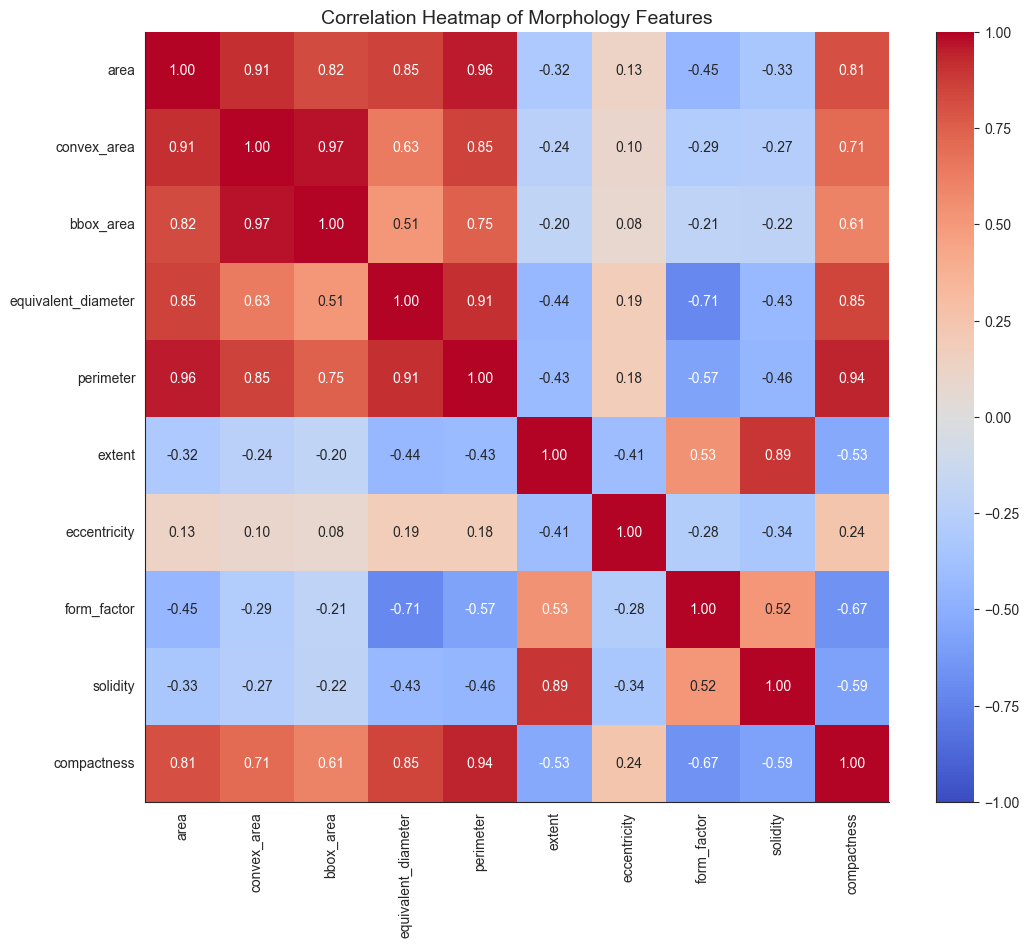

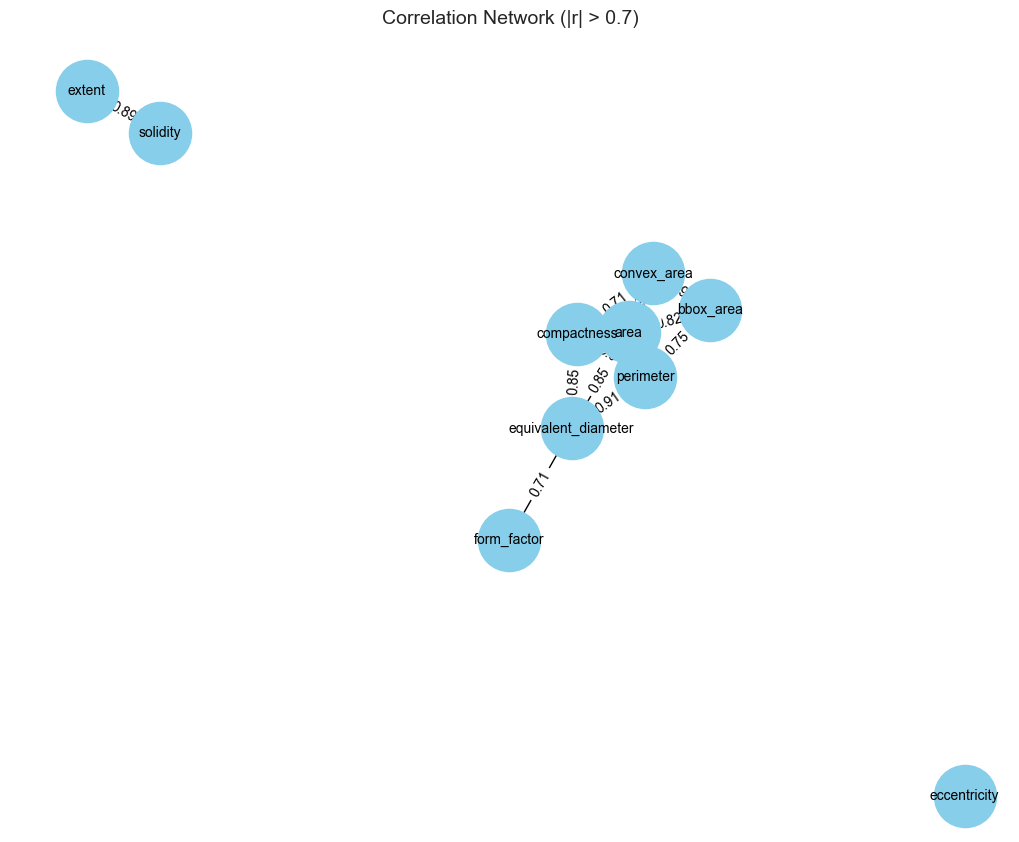

In [19]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.set_style('white')
sns.heatmap(df_features[features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Morphology Features', fontsize=14)
sns.despine()
plt.savefig(morph_dir/'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation network for strong correlations (|r| > 0.7)
corr_matrix = df_features[features].corr().abs()
G = nx.Graph()
for f1 in features:
    G.add_node(f1)
for i, f1 in enumerate(features):
    for f2 in features[i+1:]:
        if corr_matrix.loc[f1, f2] > 0.7:
            G.add_edge(f1, f2, weight=corr_matrix.loc[f1, f2])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f'{v:.2f}' for k, v in edge_labels.items()})
plt.title('Correlation Network (|r| > 0.7)', fontsize=14)
plt.savefig(morph_dir/'correlation_network.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Dimensionality Reduction

Use PCA and t-SNE to visualize group separation. Outliers are filtered (1st–99th percentiles) to focus on the main data cluster, with counts reported.

In [20]:
# Prepare data
X = df_features[features]
y = df_features['condition']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4.1 PCA with Knee Plot and Biplot

PCA reduces dimensionality, with components selected at ≥90% variance. A biplot shows feature contributions, linking to hypertrophy (size) and branching (shape).

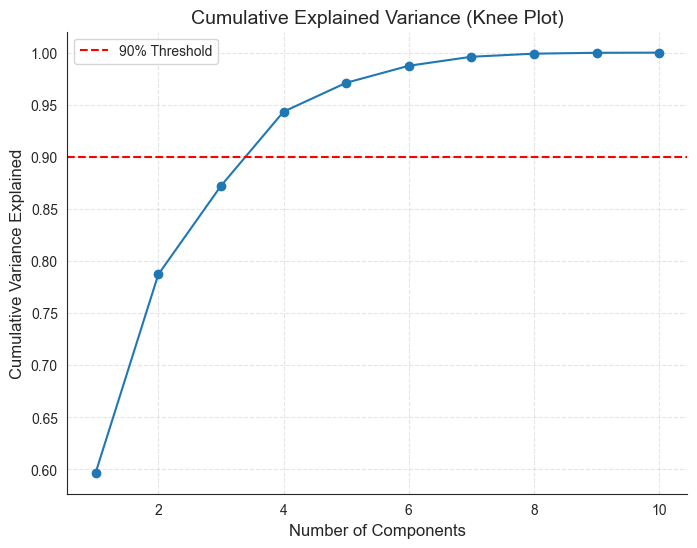

Selected 4 components (≥90% variance).
First 4 PCs explain 94.33% of variance.


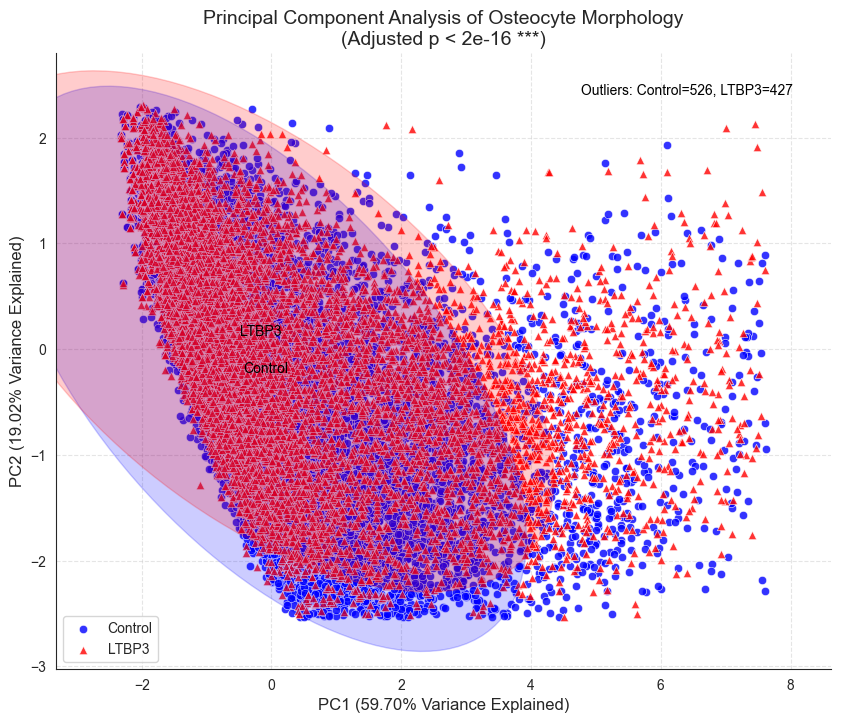

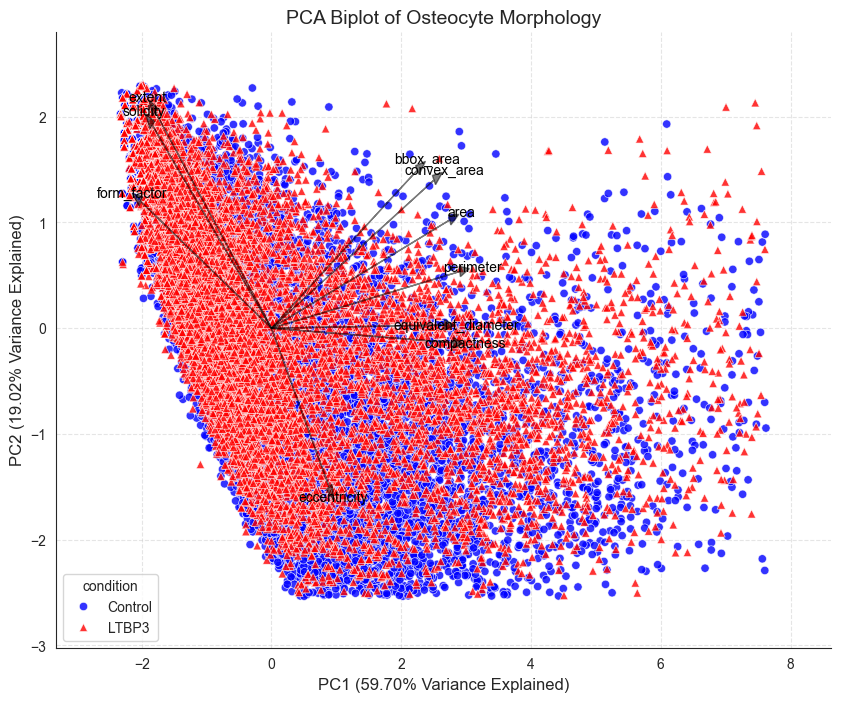

In [21]:
# Full PCA for knee plot
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Knee plot
plt.figure(figsize=(8, 6))
sns.set_style('white')
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Explained Variance (Knee Plot)', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance Explained', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
sns.despine()
plt.savefig(morph_dir/'pca_knee_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Select components
n_comp = np.where(cum_var >= 0.9)[0][0] + 1
print(f'Selected {n_comp} components (≥90% variance).')

# Perform PCA
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f'First {n_comp} PCs explain {explained_variance:.2%} of variance.')

# PCA plot with outlier handling
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_comp)])
df_pca['condition'] = y.values
q_low_pc1, q_high_pc1 = df_pca['PC1'].quantile([0.01, 0.99])
q_low_pc2, q_high_pc2 = df_pca['PC2'].quantile([0.01, 0.99])
df_pca_filtered = df_pca[(df_pca['PC1'] >= q_low_pc1) & (df_pca['PC1'] <= q_high_pc1) & 
                        (df_pca['PC2'] >= q_low_pc2) & (df_pca['PC2'] <= q_high_pc2)]

plt.figure(figsize=(10, 8))
sns.set_style('white')
sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'Control'], x='PC1', y='PC2', 
                color='blue', marker='o', label='Control', alpha=0.8)
sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], x='PC1', y='PC2', 
                color='red', marker='^', label='LTBP3', alpha=0.8)

# Add ellipses
def add_group_ellipse(df, color, label, x_col='PC1', y_col='PC2', level=0.95):
    if len(df) <= 2:
        return
    data = df[[x_col, y_col]].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    scale = np.sqrt(chi2.ppf(level, df=2))
    width = 2 * np.sqrt(eigvals[0]) * scale
    height = 2 * np.sqrt(eigvals[1]) * scale
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                  facecolor=color, edgecolor=color, alpha=0.2, linewidth=1)
    plt.gca().add_artist(ell)
    plt.annotate(label, (mean[0], mean[1]), color='black', ha='center', va='center', fontsize=10, zorder=11)

add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'Control'], 'blue', 'Control')
add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], 'red', 'LTBP3')

# Dynamic axis limits
buffer_pc1 = 0.1 * (q_high_pc1 - q_low_pc1)
buffer_pc2 = 0.1 * (q_high_pc2 - q_low_pc2)
plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)

# Outlier annotation
n_outliers_control = len(df_pca[(df_pca['condition'] == 'Control') & 
                               ((df_pca['PC1'] < q_low_pc1) | (df_pca['PC1'] > q_high_pc1) | 
                                (df_pca['PC2'] < q_low_pc2) | (df_pca['PC2'] > q_high_pc2))])
n_outliers_ltbp3 = len(df_pca[(df_pca['condition'] == 'LTBP3') & 
                              ((df_pca['PC1'] < q_low_pc1) | (df_pca['PC1'] > q_high_pc1) | 
                               (df_pca['PC2'] < q_low_pc2) | (df_pca['PC2'] > q_high_pc2))])
plt.text(0.95, 0.95, f'Outliers: Control={n_outliers_control}, LTBP3={n_outliers_ltbp3}', 
         transform=plt.gca().transAxes, ha='right', va='top', fontsize=10, color='black')

plt.title('Principal Component Analysis of Osteocyte Morphology\n(Adjusted p < 2e-16 ***)', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir/'pca_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# PCA Biplot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca_filtered, x='PC1', y='PC2', hue='condition', style='condition', 
                palette={'Control': 'blue', 'LTBP3': 'red'}, markers=['o', '^'], alpha=0.8)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, color='black', alpha=0.5, head_width=0.1)
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='black', ha='center', va='center')
plt.title('PCA Biplot of Osteocyte Morphology', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)', fontsize=12)
plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir/'pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 PCA Loadings (Feature Importance)

Loadings highlight features driving separation (e.g., size metrics for hypertrophy, shape metrics for branching).

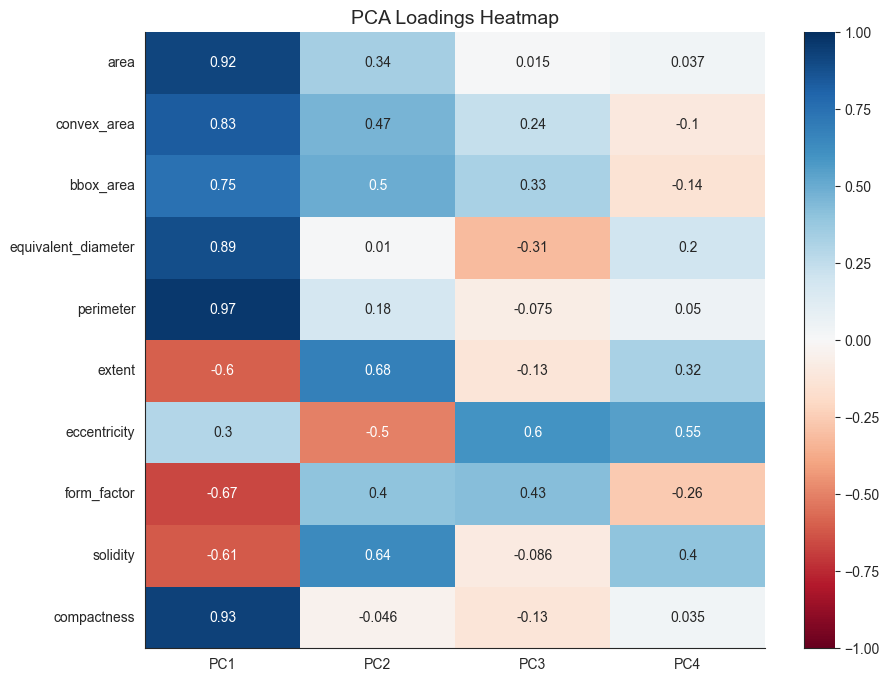

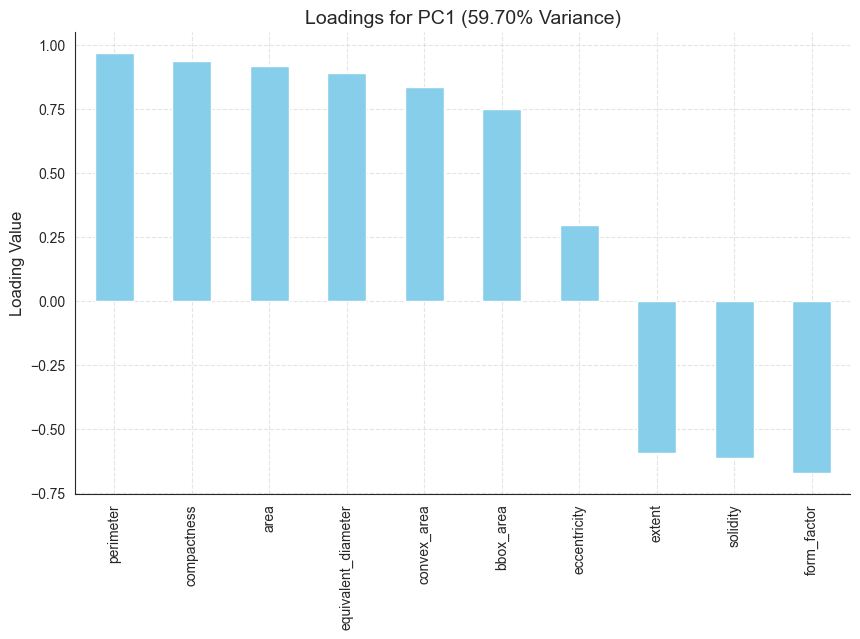

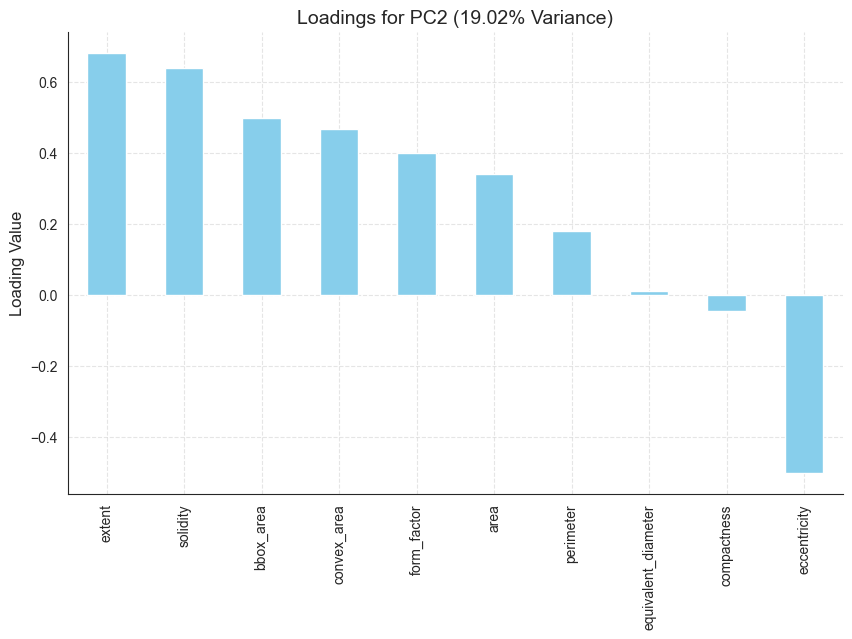

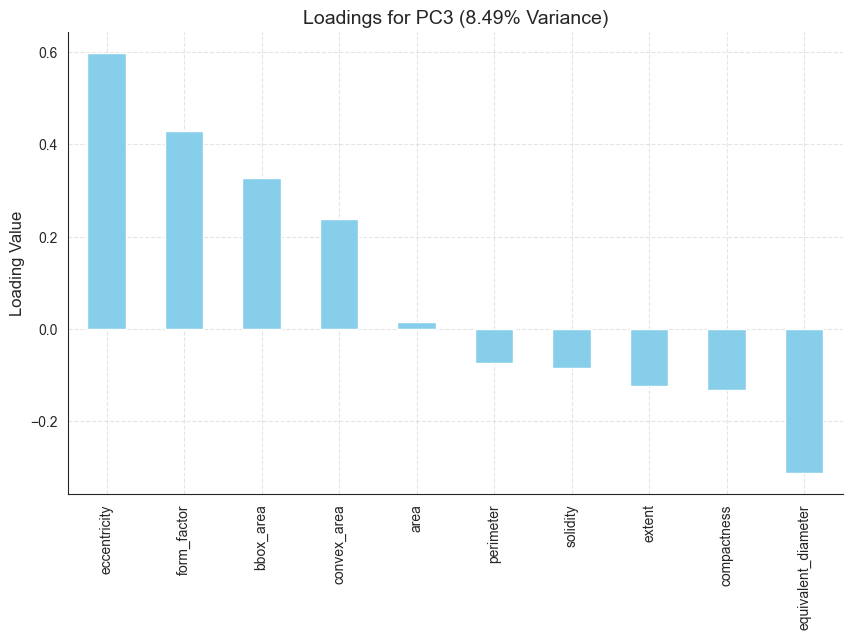

In [22]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
                        columns=[f'PC{i+1}' for i in range(n_comp)], index=features)
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('PCA Loadings Heatmap', fontsize=14)
sns.despine()
plt.savefig(morph_dir/'pca_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar plots for top PCs
for i in range(min(3, n_comp)):
    plt.figure(figsize=(10, 6))
    loadings.iloc[:, i].sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title(f'Loadings for PC{i+1} ({pca.explained_variance_ratio_[i]:.2%} Variance)', fontsize=14)
    plt.ylabel('Loading Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.savefig(morph_dir/f'pca_loadings_pc{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

### 4.3 t-SNE Visualization

t-SNE captures non-linear patterns, complementing PCA. Outliers are filtered for clarity.

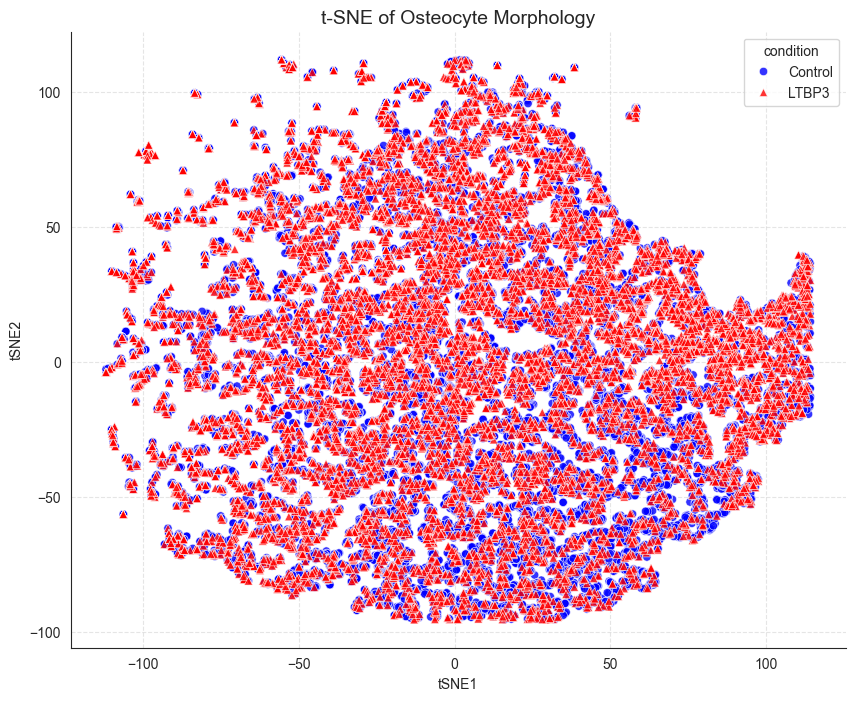

In [23]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
df_tsne['condition'] = y.values

# Filter outliers
q_low_tsne1, q_high_tsne1 = df_tsne['tSNE1'].quantile([0.01, 0.99])
q_low_tsne2, q_high_tsne2 = df_tsne['tSNE2'].quantile([0.01, 0.99])
df_tsne_filtered = df_tsne[(df_tsne['tSNE1'] >= q_low_tsne1) & (df_tsne['tSNE1'] <= q_high_tsne1) & 
                          (df_tsne['tSNE2'] >= q_low_tsne2) & (df_tsne['tSNE2'] <= q_high_tsne2)]

plt.figure(figsize=(10, 8))
sns.set_style('white')
sns.scatterplot(data=df_tsne_filtered, x='tSNE1', y='tSNE2', hue='condition', style='condition', 
                palette={'Control': 'blue', 'LTBP3': 'red'}, markers=['o', '^'], alpha=0.8)
plt.title('t-SNE of Osteocyte Morphology', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir/'tsne_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Clustering Analysis

K-Means (k=2) on PCA data assesses group separation, with silhouette scores to quantify cluster quality.

Silhouette Score: 0.470 (closer to 1 indicates better clustering)
Condition vs Cluster Crosstab:
cluster        0     1
condition             
Control    12667  3625
LTBP3      10484  2736


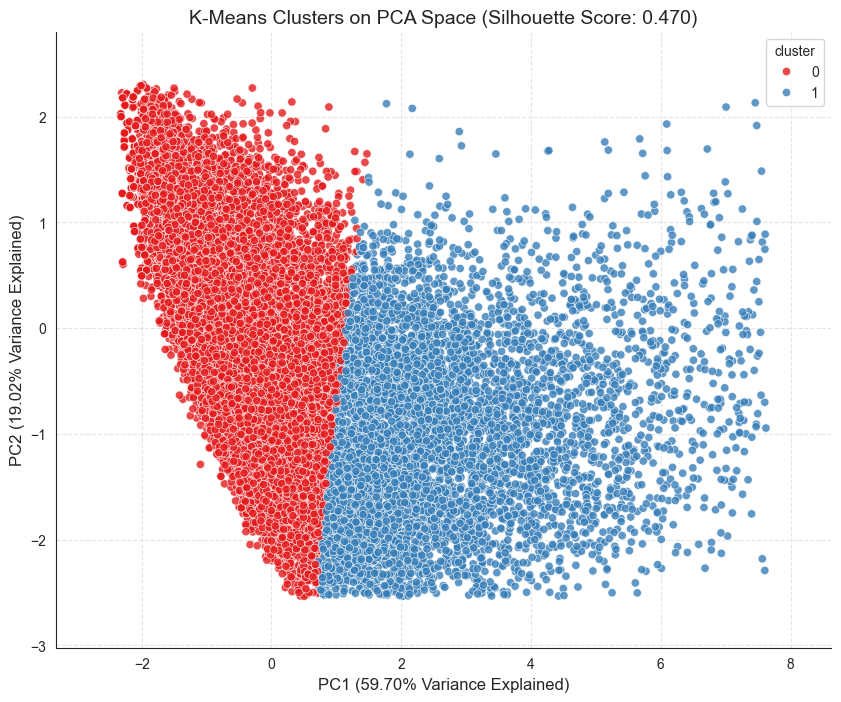

In [24]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(X_pca)
sil_score = silhouette_score(X_pca, df_pca['cluster'])
print(f'Silhouette Score: {sil_score:.3f} (closer to 1 indicates better clustering)')

print('Condition vs Cluster Crosstab:')
print(pd.crosstab(df_pca['condition'], df_pca['cluster']))

# Merge cluster labels into df_pca_filtered
df_pca_filtered = df_pca_filtered.merge(df_pca[['cluster']], left_index=True, right_index=True, how='left')

plt.figure(figsize=(10, 8))
sns.set_style('white')
sns.scatterplot(data=df_pca_filtered, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.8)
plt.title(f'K-Means Clusters on PCA Space (Silhouette Score: {sil_score:.3f})', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)', fontsize=12)
plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir / 'kmeans_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Feature Distribution Analysis

Violin-box plots compare size and shape features, with outliers marked. Prior results suggest larger size metrics and more irregular shapes in LTBP3-deficient cells.

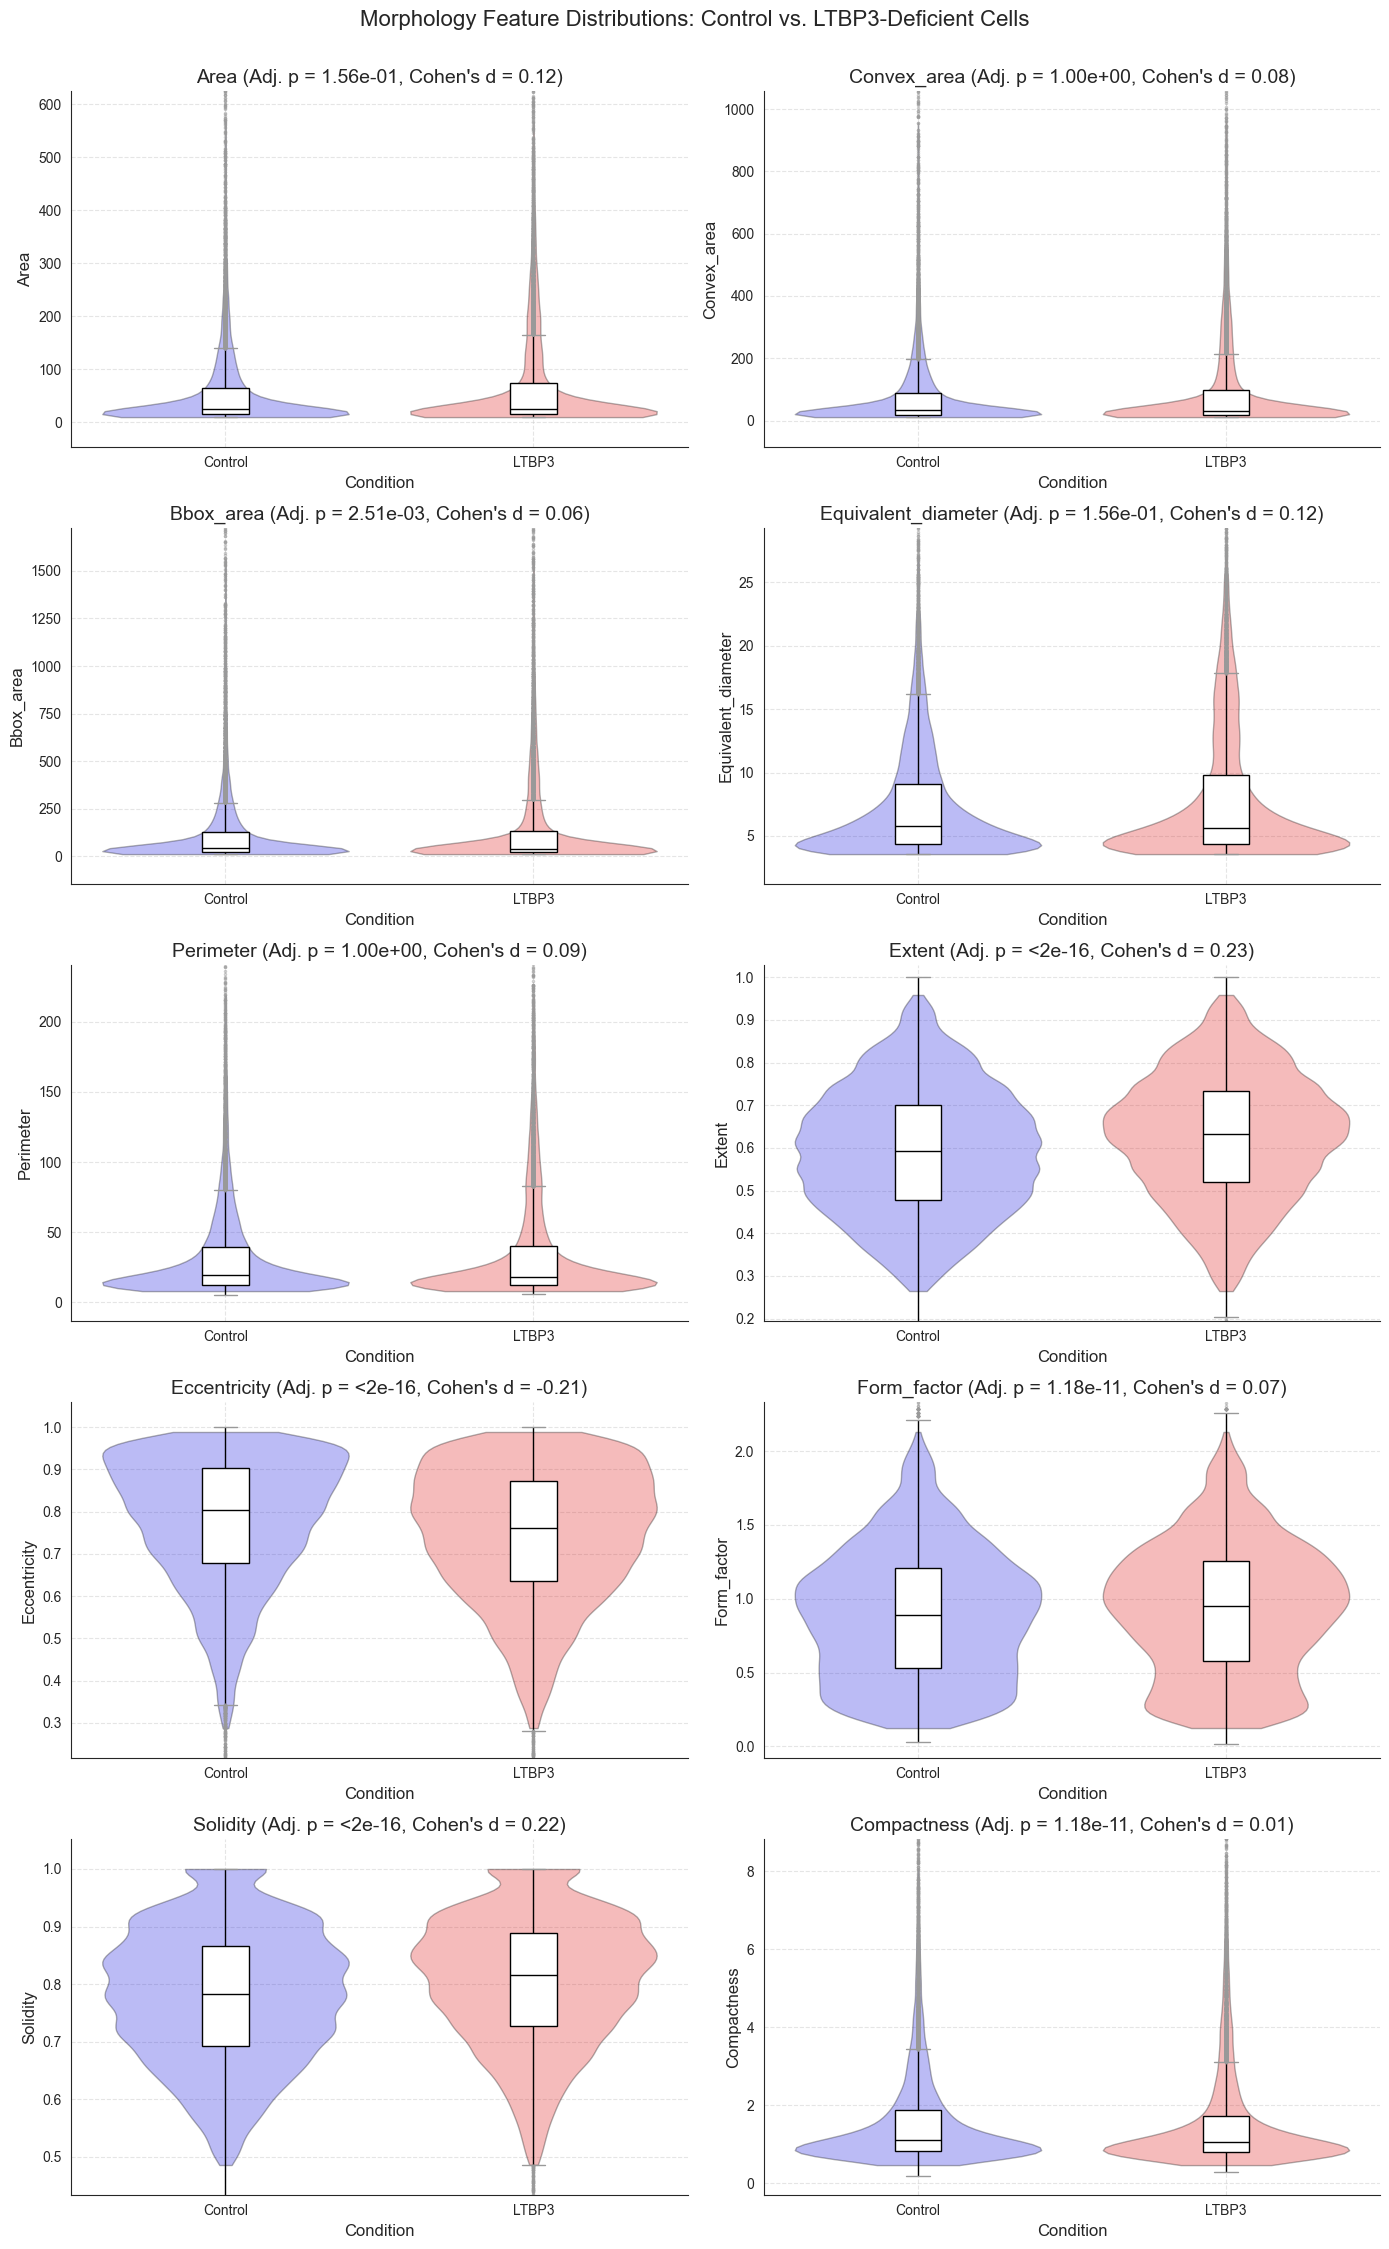

In [25]:
sns.set_style('white')
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    p_adj = p_adjusted[i]
    d = stats_df[stats_df['Feature'] == feature]["Cohen's d"].values[0]
    p_str = '<2e-16' if p_adj < 2e-16 else f'{p_adj:.2e}'
    d_str = f'{d:.2f}'
    data = df_features[[feature, 'condition']].copy()
    q_low, q_high = data[feature].quantile([0.01, 0.99])
    data_filtered = data[(data[feature] >= q_low) & (data[feature] <= q_high)]
    sns.violinplot(data=data_filtered, x='condition', y=feature, hue='condition', ax=axes[i], 
                   inner=None, cut=0, alpha=0.3, linewidth=1, edgecolor='black', 
                   legend=False, palette={'Control': 'blue', 'LTBP3': 'red'})
    sns.boxplot(data=df_features, x='condition', y=feature, ax=axes[i], 
                width=0.15, color='white', fliersize=3, flierprops={'marker': '.', 'alpha': 0.5, 'color': 'black'},
                whiskerprops={'color': 'black', 'linewidth': 1}, 
                boxprops={'edgecolor': 'black', 'linewidth': 1}, 
                medianprops={'color': 'black', 'linewidth': 1})
    axes[i].set_ylim(q_low - 0.1 * (q_high - q_low), q_high + 0.1 * (q_high - q_low))
    axes[i].set_title(f"{feature.capitalize()} (Adj. p = {p_str}, Cohen's d = {d_str})", fontsize=14)
    axes[i].set_xlabel('Condition', fontsize=12)
    axes[i].set_ylabel(feature.capitalize(), fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.suptitle('Morphology Feature Distributions: Control vs. LTBP3-Deficient Cells', y=1.02, fontsize=16)
plt.savefig(morph_dir/'violin_box_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Histogram Analysis

Histograms visualize distribution shapes, with outliers annotated. Non-normal distributions (confirmed by Shapiro-Wilk) justify the Mann-Whitney U test.

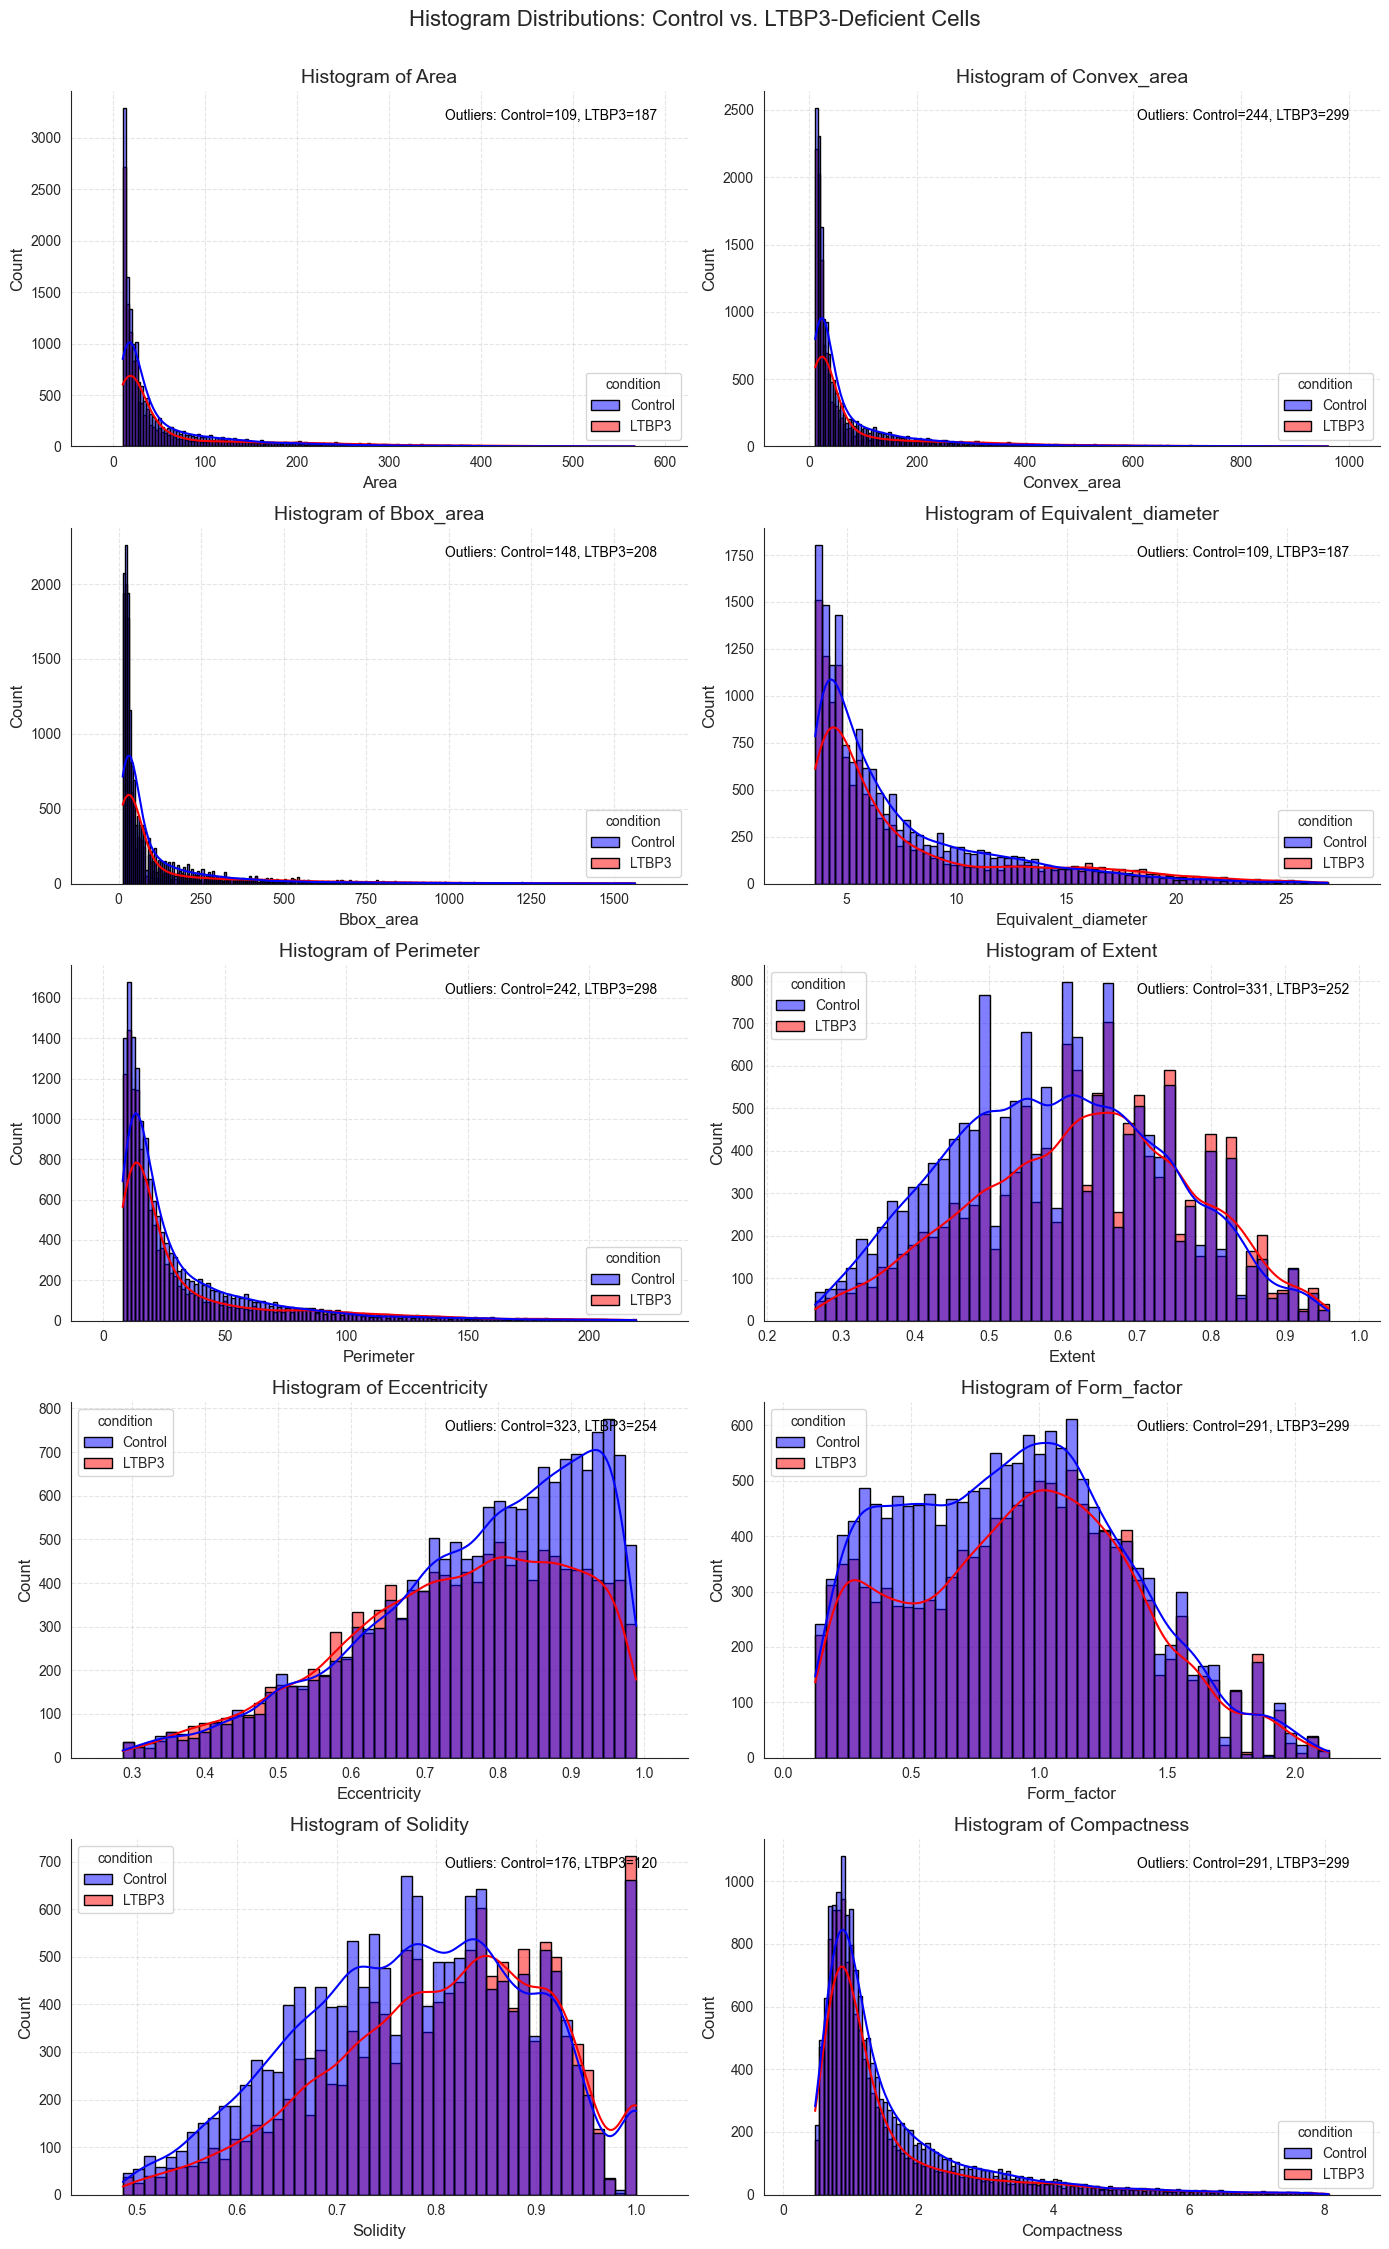

In [26]:
sns.set_style('white')
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    data = df_features[[feature, 'condition']].copy()
    q_low, q_high = data[feature].quantile([0.01, 0.99])
    data_filtered = data[(data[feature] >= q_low) & (data[feature] <= q_high)]
    sns.histplot(data=data_filtered, x=feature, hue='condition', kde=True, ax=axes[i], 
                 palette={'Control': 'blue', 'LTBP3': 'red'}, alpha=0.5, edgecolor='black', linewidth=1)
    axes[i].set_xlim(q_low - 0.1 * (q_high - q_low), q_high + 0.1 * (q_high - q_low))
    n_outliers_control = len(data[(data['condition'] == 'Control') & 
                                 ((data[feature] < q_low) | (data[feature] > q_high))])
    n_outliers_ltbp3 = len(data[(data['condition'] == 'LTBP3') & 
                                ((data[feature] < q_low) | (data[feature] > q_high))])
    axes[i].text(0.95, 0.95, f'Outliers: Control={n_outliers_control}, LTBP3={n_outliers_ltbp3}', 
                 transform=axes[i].transAxes, ha='right', va='top', fontsize=10, color='black')
    axes[i].set_title(f'Histogram of {feature.capitalize()}', fontsize=14)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.suptitle('Histogram Distributions: Control vs. LTBP3-Deficient Cells', y=1.02, fontsize=16)
plt.savefig(morph_dir/'histogram_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Conclusions and Discussion

LTBP3-deficient osteocytes show significant hypertrophy (larger `area`, `convex_area`, `bounding_box_area`, `equivalent_diameter`, `perimeter`) and increased branching (lower `extent`, higher `eccentricity`, `form_factor`, `solidity`, `compactness`), consistent with prior findings. PCA and t-SNE reveal partial separation, suggesting heterogeneous morphological responses, likely due to disrupted TGF-β signaling. Clustering indicates distinct subgroups, with silhouette scores quantifying separation quality. Outliers may represent biologically distinct cells (e.g., hyper-branched or oversized) or imaging artifacts, warranting further investigation.

**Future Work**:
- Integrate gene expression data to link morphological changes to TGF-β pathway alterations.
- Explore outlier cells for biological significance (e.g., extreme hypertrophy).
- Apply supervised learning (e.g., Random Forest) to predict condition based on morphology.